<a href="https://colab.research.google.com/github/x3gan/elte-msc/blob/main/Deep%20Network%20Development/GPU_PyTorch_25_26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyTorch GPU Integration**

<div style="border: 3px solid #222; padding: 16px; border-radius: 10px; background-color: #1c1f26; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; color: #e0e0e0;">
  <div style="display: flex; align-items: center; gap: 8px; margin-top: 12px;">
    <span style="font-size: 24px; color: #ff5555;">&#128274;</span>
    <span style="font-size: 16px;"><strong>Project:</strong> Introduction</span>
  </div>
  <div style="display: flex; align-items: center; gap: 8px; margin-top: 8px;">
    <span style="font-size: 20px; color: #ff5555;">&#128218;</span>
    <span style="font-size: 16px;"><strong>Course:</strong> Deep Network Development</span>
  </div>
  <div style="margin-top: 12px; font-size: 14px;">
    <span style="font-size: 18px; color: #6e8192;">&#128100;</span>
    <span style="font-weight: bold;"><strong>Authors:</strong></span> Tamás Takács, Imre Molnár (PhD students, Department of Artificial Intelligence, Eötvös Loránd University)
  </div>
</div>
<hr style="border: none; border-top: 2px solid #444;">
<br>

<img src="https://i.ibb.co/QqX9V4N/News-Image-2023-11-22-T133344-154-1.png" alt="News-Image-2023-11-22-T133344-154-1" border="0">

PyTorch provides seamless GPU integration through its native CUDA interface, allowing developers to effortlessly transfer tensors and models to GPU devices for optimized parallel computation. This integration accelerates the training and inference of complex neural networks.

In [ ]:
# @title Roadmap Generator
%%capture flowchart_output
from graphviz import Digraph

def create_gpu_pytorch_flowchart(output_filename='gpu_pytorch_flowchart'):
    dot = Digraph(name='GPU_PyTorch', format='png')
    dot.attr(rankdir='LR')
    dot.attr('node', shape='box', style='filled', fontsize='12', fontname='Arial')

    # Nodes (colors: green = easy, yellow = moderate, red = difficult)
    dot.node('Setup', 'Import Libraries & Setup\n(Easy)', fillcolor='#A0E7A0')
    dot.node('GPUInfo', 'GPU Monitoring (nvidia-smi)\n(Easy)', fillcolor='#A0E7A0')
    dot.node('TensorOps', 'Tensor Creation, Conversion & Matrix Ops\n(Moderate)', fillcolor='#F6D49A')
    dot.node('Perf', 'Parallel Computations & Performance Benchmarking\n(Moderate)', fillcolor='#F6D49A')

    # Define the pipeline flow
    dot.edge('Setup', 'GPUInfo')
    dot.edge('GPUInfo', 'TensorOps')
    dot.edge('TensorOps', 'Perf')

    dot.render(output_filename, view=False)

create_gpu_pytorch_flowchart('gpu_pytorch_flowchart')


## **Necessary Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from IPython.display import Image as IMG

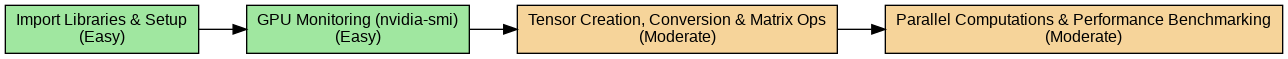

In [ ]:
IMG('gpu_pytorch_flowchart.png')

## **GPU**

Basic GPU monitoring informations that can be useful. `!nvidia-smi` (NVIDIA Management Library) can be used to get a summary table. Unfortunately, it cannot be called directly, so other libraries must be used to monitor the gpu in the program. Currently, it only works stably on Nvidia GPUs. To take advantage of the GPU, Cuda Toolkit "https://developer.nvidia.com/cuda-downloads" needs to be installed first.

In [ ]:
!nvidia-smi

Tue Aug 13 04:02:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## **PyTorch**

At its core PyTorch provides two features:
1.   An n-dimensional Tensor, similar to NumPy but switches easily between CPU and GPUs.
2.   Automatic differentiation for building and training (neural) networks.


Let's take a look on some common features: \\
- `numpy.ndarray` vs `torch.tensor` \\
- `numpy.ones` vs `torch.ones` \\
- `numpy.zeros` vs `torch.zeros` \\
- `numpy.copy()` vs `torch.clone()` \\
- `.reshape` vs `.view` (numpy vs torch) \\
- `numpy.linalg.inv()` vs `torch.inverse()` \\
- `torch.from_numpy()` \\
- `torch.where()` \\

### **Numpy vs Torch**

Two additional parameters can be specified for the Torch tensor. The device can be 'cpu' or cuda, where the number can be selected. The need for a gradient increases its space requirements but is necessary for training.

In [ ]:
#install cudatoolkit
my_tensor = torch.tensor(data=[2.5], dtype=torch.float64, device='cuda:0', requires_grad=True)

In [ ]:
numpy_array = np.array([[1.0,3.2,0],[3.3,4.1,0]], dtype=np.float16)
print(f'numpy_array type: {type(numpy_array)}')
tensor = torch.from_numpy(numpy_array)
print(f'tensor type: {type(tensor)}')

numpy_array type: <class 'numpy.ndarray'>
tensor type: <class 'torch.Tensor'>


In [ ]:
print(tensor.shape)
print(tensor.size(0)) # same as .shape and you can specify the dimension
print(tensor.dim())

torch.Size([2, 3])
2
2


#### **Difference in execution time - numpy vs pytorch**

The comparison should consider the conversion time and the time of data movement to/from the GPU memory. Because of the copy times, when possible it is worth initializing variables directly on the GPU.

- `%%time`-total execution time of the cell,
- `%time` -next line execution time, only for Win64 (Win32 chase=0)
- Compiler time: shows up if>0.1 s
- Wall time: time diff.(kernel start and end)
- user: code execution time (maybe more than wall time in paralell case)
- sys: pre and after processes (memory allocation...)
- CPU time is user time + sys time


In [ ]:
matrix_1 = np.random.randn(5000,5000)
matrix_2 = np.random.randn(5000,5000)

In [ ]:
%%time
res_numpy = np.dot(matrix_1, matrix_2)
print(res_numpy[0])

[ -47.99112421  -87.82726155  -55.99136678 ...  -77.7400173   -26.83048607
 -226.77892049]
CPU times: user 7.69 s, sys: 170 ms, total: 7.86 s
Wall time: 4.26 s


In [ ]:
torch_mx_1 = torch.from_numpy(matrix_1).float().cuda()
torch_mx_2 = torch.from_numpy(matrix_2).float().cuda()

In [ ]:
%%time
# torch_mx_1 = torch.from_numpy(matrix_1).float().cuda()
# torch_mx_2 = torch.from_numpy(matrix_2).float().cuda()
res_pytorch = torch.mm(torch_mx_1, torch_mx_2)
print(res_pytorch[0])

tensor([ -47.9911,  -87.8272,  -55.9913,  ...,  -77.7399,  -26.8305,
        -226.7791], device='cuda:0')
CPU times: user 158 ms, sys: 80.9 ms, total: 238 ms
Wall time: 635 ms


#### **Matrix inverse, determinant and transpose**

Try different types and devices and check accuracy and speed.

In [ ]:
n = np.array([[2.,3.],[5.,5.]], dtype=np.float32)
p = torch.tensor([[2.,3.],[5.,5.]], dtype=torch.float32, device='cuda:0')

print(f'numpy inverse:\n {np.linalg.inv(n)}')
print(f'torch inverse:\n {p.inverse()}')
print()

print(f'numpy determinant:\n {np.linalg.det(n)}')
print(f'torch determinant:\n {torch.det(p)}')
print()

print(f'numpy transpose:\n {n.T}')
print(f'torch transpose:\n {p.t()}')
print()


numpy inverse:
 [[-1.   0.6]
 [ 1.  -0.4]]
torch inverse:
 tensor([[-1.0000,  0.6000],
        [ 1.0000, -0.4000]], device='cuda:0')

numpy determinant:
 -5.0
torch determinant:
 -4.999999523162842

numpy transpose:
 [[2. 5.]
 [3. 5.]]
torch transpose:
 tensor([[2., 5.],
        [3., 5.]], device='cuda:0')



#### **Reshape**

In [ ]:
n = np.array([[2.,3.,0.,2.],[5.,5.,3.,2.]])
p = torch.tensor([[2.,3.,0.,2.],[5.,5.,3.,2.]], device='cuda:0')

print(n.reshape((1,4,2)))
print(p.view((2,4,1)))
print(p.reshape((4,2,1)))
p

[[[2. 3.]
  [0. 2.]
  [5. 5.]
  [3. 2.]]]
tensor([[[2.],
         [3.],
         [0.],
         [2.]],

        [[5.],
         [5.],
         [3.],
         [2.]]], device='cuda:0')
tensor([[[2.],
         [3.]],

        [[0.],
         [2.]],

        [[5.],
         [5.]],

        [[3.],
         [2.]]], device='cuda:0')


tensor([[2., 3., 0., 2.],
        [5., 5., 3., 2.]], device='cuda:0')

####  **Parallel calculations**

GPU calculations do not take CPU time.

A simple parallel task where values smaller than 0 are replaced by pi

In [ ]:
x_torch = torch.randn(10000, 10000, dtype=torch.double, device='cuda:0')
x_numpy = np.random.randn(10000,10000)
# directly on GPU
S2 = torch.Size((100, 100))
x = torch.cuda.HalfTensor(S2)
torch.randn(S2, out=x)

<ipython-input-12-3db1e3d59094>:5: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:78.)
  x = torch.cuda.HalfTensor(S2)


tensor([[ 1.1543, -0.0870, -0.6357,  ...,  0.7729, -1.8184,  1.0146],
        [-0.0368,  1.7432, -1.7773,  ..., -0.7139, -0.6562,  0.3630],
        [ 0.0455, -0.8540,  0.1711,  ..., -0.2925, -1.8477,  0.0518],
        ...,
        [ 1.6680,  0.2681, -0.1237,  ..., -1.0850, -1.3447,  0.4875],
        [ 1.4766, -0.9688, -0.0275,  ...,  0.3203,  0.1554, -0.1052],
        [-0.3711, -1.0449, -0.2446,  ...,  0.4783, -0.4148,  0.4751]],
       device='cuda:0', dtype=torch.float16)

In [ ]:
%%time
tstart = time.time()
x_torch=torch.where(x_torch > 0, x_torch, torch.pi)
thalf = time.time()
x_numpy=np.where(x_numpy > 0, x_numpy, np.pi)
tend = time.time()
print('GPU calculation time pytorch: ',thalf-tstart, ' s')
print('CPU calculation time numpy: ',tend-thalf, ' s')

GPU calculation time pytorch:  0.050916194915771484  s
CPU calculation time numpy:  0.7665483951568604  s
CPU times: user 619 ms, sys: 163 ms, total: 783 ms
Wall time: 820 ms


### **HOMEWORK (Optional)**

- **Exercise 1: Matrix Multiplication Benchmark**  
  Create two large random matrices (e.g., 10,000 x 10,000) using both numpy (on CPU) and PyTorch (on GPU). Perform matrix multiplication on both and measure the execution times. Compare the results and explain why the GPU implementation is faster.

- **Exercise 2: Conditional Element-wise Operations**  
  Generate a large array/tensor of random numbers. Using `np.where` (on CPU) and `torch.where` (on GPU), replace all negative values with a constant (e.g., π). Measure and compare the performance of these operations, and discuss the advantages of GPU acceleration.

- **Exercise 3: Data Transfer Overhead**  
  Create a small tensor on the CPU, transfer it to the GPU, and then back to the CPU. Measure the time taken for these transfers. Analyze the overhead involved in data transfers between CPU and GPU and discuss strategies to minimize this overhead.

- **Exercise 4: Broadcasting and Vectorized Operations**  
  Create two large arrays/tensors and perform element-wise arithmetic operations (such as addition, subtraction, and multiplication) using broadcasting in numpy (on CPU) and PyTorch (on GPU). Compare the execution times and explain how broadcasting and vectorization contribute to performance improvements on the GPU.

- **Exercise 5: GPU Memory Management**  
  Write a program that creates multiple large PyTorch tensors on the GPU and performs various operations on them. Experiment with `torch.cuda.empty_cache()` to free unused memory and observe how effective memory management can improve overall performance in GPU computations.